# <center> Milestone 3: Machine Learning Implementations </center>

### <center> Authors: Albina Cako & Joshua Dalphy </center>

# Table of Contents

* [1. Getting Started](#1)
* [2. Data Transformation](#2)
 * [2.1) Stemming the Dataset](#2.1)
 * [2.2) Removing Numerical Values](#2.2)
* [3. Feature Extraction](#3)
* [4. Modelling](#4)
 * [4.1) Logistic Regression Model](#4.1)
   * [4.1.1) Baseline Model](#4.1.1)
   * [4.1.2) Hyperparameter Tuning](#4.1.2)
 * [4.2) Naive Bayes Model](#4.2)
   * [4.2.1) Baseline Model](#4.2.1)
   * [4.2.2) Hyperparameter Tuning](#4.2.2)
 * [4.3) Random Forest Model](#4.2)
   * [4.3.1) Baseline Model](#4.2.1)
   * [4.3.2) Hyperparameter Tuning](#4.2.2)
* [5. Ensemble Learning](#5)
 * [5.1) Bagging](#5.1)
 * [5.2) Stacking](#5.2)
 * [5.2) Boosting](#5.2)


# 1. Getting Started<a class="anchor" id="1"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import model_evaluation_utils as meu

# Set print options
np.set_printoptions(precision=2, linewidth=80)

# Load the cleaned preprocessed dataset
dataset = pd.read_csv('Movie_Reviews_Clean.csv')

# Remove extra column
dataset = dataset.drop(columns=['Unnamed: 0'])

# replace positive with 1 and negative with 0
dataset.Sentiments = dataset.Sentiments.replace('positive',1)
dataset.Sentiments = dataset.Sentiments.replace('negative',0)

dataset = shuffle(dataset)

# Retrieve the reviews
dataset.head(3)

,Reviews,Sentiments
5949,ghost vietnam war haunt american psyche thirty...,0
4732,really surprised movie get ranking like not se...,0
5705,horrible writing acting no personality not mak...,0


In [2]:
#dataset = dataset[:500]
# Retrieve the reviews
#dataset.head(3)

In [3]:
# Create a reivew and sentiment array
reviews = np.array(dataset['Reviews'])
sentiment = np.array(dataset['Sentiments'])

# Split the reviews into testing and training 70/30
index = round(0.7*len(reviews))

train_reviews = reviews[:index]
test_reviews  = reviews[index:]

train_sentiments = sentiment[:index]
test_sentiments  = sentiment[index:]

# 2. Data Transformation<a class="anchor" id="2"></a>

## 2.1) Stemming the Dataset<a class="anchor" id="2.1"></a>

In [4]:
#import nltk
#nltk.download()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
porter = PorterStemmer()

def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [5]:
# Apply the stemming function on train_reviews
stem_train_reviews = [None]*len(train_reviews)
idx = 0
for sentence in train_reviews:
    stem_train_reviews[idx] = stemSentence(sentence)
    idx = idx + 1   

# Apply the stemming function on test_reviews
stem_test_reviews = [None]*len(test_reviews)
idx = 0
for sentence in test_reviews:
    stem_test_reviews[idx] = stemSentence(sentence)
    idx = idx + 1  

    
train_reviews = stem_train_reviews  
test_reviews  = stem_test_reviews 

In [6]:
# Get the length of the training set
len(train_reviews)

4900

## 2.2) Removing Numerical Values<a class="anchor" id="2.2"></a>

In [7]:
# Define a function to remove digits from a sentence
import re
def remove_digits(text):
    text = re.sub(r'[0-9]+', '', text)
    #text = re.sub('[^a-zA-Z\s]', '', text)
    return text

In [8]:
# Apply the function to train_reviews
remove_digits_train = []
for doc in train_reviews:
    doc = remove_digits(doc)
    remove_digits_train.append(doc)

# Apply the function to test_reviews
remove_digits_test = []
for doc in test_reviews:
    doc = remove_digits(doc)
    remove_digits_test.append(doc)

    
train_reviews = remove_digits_train
test_reviews = remove_digits_test

# 3. Feature Extraction<a class="anchor" id="3"></a>

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [49]:
# build TFIDF features on train reviews
BOW_tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,1),
                     sublinear_tf=True)
BOW_tv_train_features = BOW_tv.fit_transform(train_reviews)

# transform test reviews into features
BOW_tv_test_features = BOW_tv.transform(test_reviews)

In [50]:
print('TFIDF model:> Train features shape:', BOW_tv_train_features.shape, ' Test features shape:', BOW_tv_test_features.shape)

TFIDF model:> Train features shape: (4900, 24652)  Test features shape: (2100, 24652)


In [51]:
# Visualize some of the features
bow_tv_feature_names = BOW_tv.get_feature_names()

BOW_tv_matrix = BOW_tv_train_features.toarray()
bow_tv_df = pd.DataFrame(BOW_tv_matrix, columns=bow_tv_feature_names)
bow_tv_df.iloc[0:3,2000:2010]

,beth,bethani,bethlehem,bethun,betrail,betray,betroth,betsi,bett,better
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065104
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# 4. Modelling<a class="anchor" id="4"></a>

## 4.1) Logistic Regression Model<a class="anchor" id="4.1"></a>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

### 4.1.1) Baseline Model<a class="anchor" id="4.1.1"></a>

In [14]:
%%time
#lr_bow_tfidf = LogisticRegression(penalty='l2', max_iter=200, C=1)
lr_bow_tfidf = LogisticRegression(max_iter=200)
# Logistic Regression model on BOW-TF-IDF features
lr_bow_tfidf_predictions = meu.train_predict_model(classifier=lr_bow_tfidf, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)

CPU times: user 1.1 s, sys: 8.63 ms, total: 1.11 s
Wall time: 153 ms


In [15]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_tfidf_predictions,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8886
Precision: 0.8887
Recall: 0.8886
F1 Score: 0.8886

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.88      0.90      0.89      1055
           0       0.90      0.88      0.89      1045

    accuracy                           0.89      2100
   macro avg       0.89      0.89      0.89      2100
weighted avg       0.89      0.89      0.89      2100


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        948  107
        0        127  918


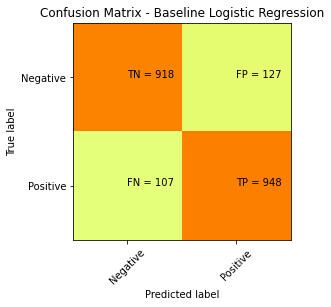

In [16]:
from sklearn.metrics import confusion_matrix,auc
import matplotlib.pyplot as plt

cm = confusion_matrix(test_sentiments, lr_bow_tfidf_predictions)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Baseline Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()



No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.958


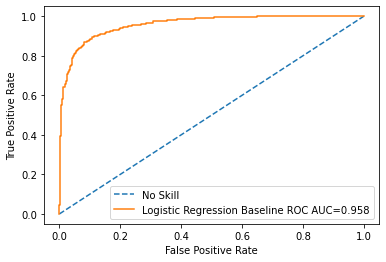

In [17]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs = lr_bow_tfidf.predict_proba(BOW_tv_test_features)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_sentiments, ns_probs)
lr_auc = roc_auc_score(test_sentiments, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_sentiments, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_sentiments, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Logistic Regression Baseline ROC AUC=%.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

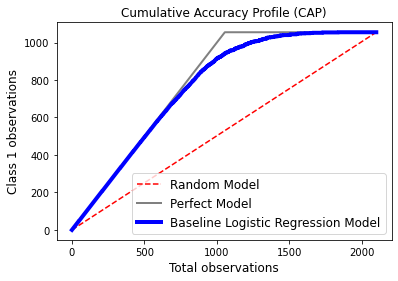

In [18]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
#plt.figure(figsize = (20, 12))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_bow_tfidf.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Baseline Logistic Regression Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [19]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Baseline Logistic Regression Model: {}".format(aR / aP))

Accuracy Rate for Baseline Logistic Regression Model: 0.9155191727703577


Percentage: 89.005%


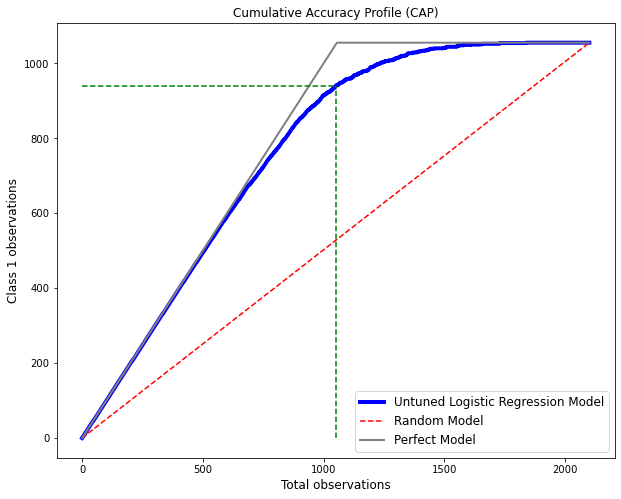

In [20]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Untuned Logistic Regression Model', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

88.20% is showing that we have a very good model. It does not show overfitting

### 4.1.2) Hyperparameter Tuning<a class="anchor" id="4.1.2"></a>

In [21]:
from sklearn.model_selection import GridSearchCV

penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=lr_bow_tfidf,
                    param_grid=param_grid,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1)
grid_result = grid.fit(BOW_tv_train_features, train_sentiments)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

#lr_bow_tfidf_tuned = grid.fit(BOW_tv_train_features, train_sentiments)
#print('Best Score: ', lr_bow_tfidf_tuned.best_score_)
#print('Best Params: ', lr_bow_tfidf_tuned.best_params_)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:    4.3s


Best Score:  0.9623813815493321
Best Params:  {'C': 100, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l2', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.5min finished


In [22]:
# Create the tuned model
lr_bow_tfidf_tuned = LogisticRegression(penalty = 'l2',C = 100,class_weight={1: 0.7, 0: 0.3}, solver= 'liblinear', max_iter=200)

# Logistic Regression model on BOW-TF-IDF features
lr_bow_tfidf_predictions_tuned = meu.train_predict_model(classifier=lr_bow_tfidf_tuned, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)


In [23]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=lr_bow_tfidf_predictions_tuned,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8981
Precision: 0.8996
Recall: 0.8981
F1 Score: 0.898

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.88      0.93      0.90      1055
           0       0.92      0.87      0.89      1045

    accuracy                           0.90      2100
   macro avg       0.90      0.90      0.90      2100
weighted avg       0.90      0.90      0.90      2100


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        981   74
        0        140  905


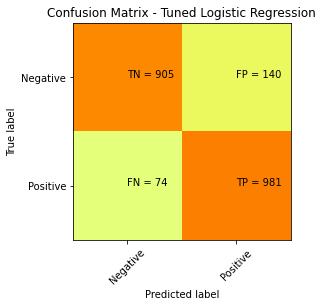

In [24]:
# Display confusion matrix for hypertuned Logistic Regression
cm = confusion_matrix(test_sentiments,lr_bow_tfidf_predictions_tuned)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tuned Logistic Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


In [25]:
# generate a no skill prediction (majority class)
ns_probs_tuned = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs_tuned = lr_bow_tfidf_tuned.predict_proba(BOW_tv_test_features)
# keep probabilities for the positive outcome only
lr_probs_tuned = lr_probs_tuned[:, 1]
# calculate scores
ns_auc_tuned = roc_auc_score(test_sentiments, ns_probs_tuned)
lr_auc_tuned = roc_auc_score(test_sentiments, lr_probs_tuned)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc_tuned))
print('Logistic Regression: ROC AUC=%.3f' % (lr_auc_tuned))

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.962


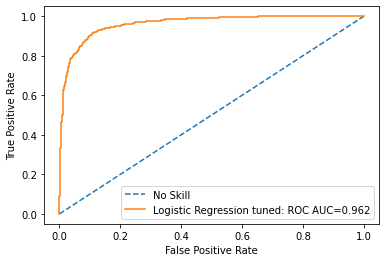

In [26]:
# calculate roc curves
ns_fpr_tuned, ns_tpr_tuned, _ = roc_curve(test_sentiments, ns_probs_tuned)
lr_fpr_tuned, lr_tpr_tuned, _ = roc_curve(test_sentiments, lr_probs_tuned)
# plot the roc curve for the model
pyplot.plot(ns_fpr_tuned, ns_tpr_tuned, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr_tuned, lr_tpr_tuned, label='Logistic Regression tuned: ROC AUC=%.3f' % (lr_auc_tuned))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

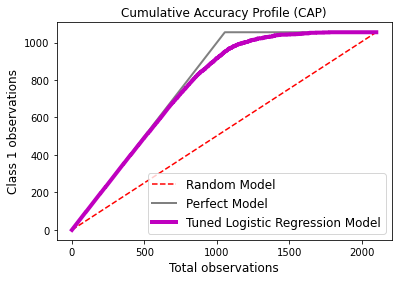

In [27]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
#plt.figure(figsize = (20, 12))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = lr_bow_tfidf_tuned.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Logistic Regression Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [28]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Logistic Regression Model: {}".format(aR / aP))

Accuracy Rate for Tuned Logistic Regression Model: 0.9236082450849226


Percentage: 89.858%


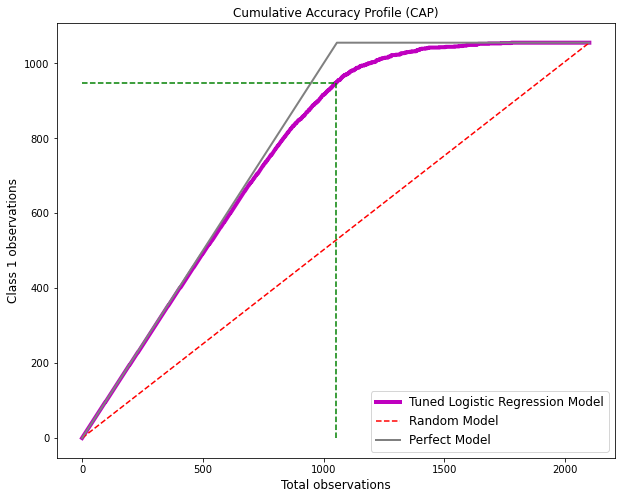

In [29]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Logistic Regression Model', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

### 4.1.3) Comparison of Results<a class="anchor" id="4.1.3"></a>

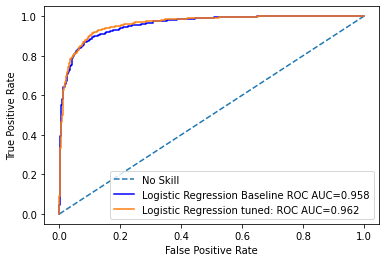

In [30]:
# plot the roc curve for the model
pyplot.plot(ns_fpr_tuned, ns_tpr_tuned, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Logistic Regression Baseline ROC AUC=%.3f' % (lr_auc),color = 'b')
pyplot.plot(lr_fpr_tuned, lr_tpr_tuned, label='Logistic Regression tuned: ROC AUC=%.3f' % (lr_auc_tuned))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## 4.2) Naive Bayes<a class="anchor" id="4.2"></a>

In [31]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

### 4.2.1) Baseline Model<a class="anchor" id="4.2.1"></a>

In [32]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(BOW_tv_train_features.toarray(), train_sentiments)

#Predict the response for test dataset
y_pred = gnb.predict(BOW_tv_test_features.toarray())

In [33]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_sentiments, y_pred))

Accuracy: 0.7771428571428571


In [34]:
# Display the confusion matrix for the naive bayes model
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=y_pred,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.7771
Precision: 0.7772
Recall: 0.7771
F1 Score: 0.7771

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.78      0.78      0.78      1055
           0       0.78      0.77      0.78      1045

    accuracy                           0.78      2100
   macro avg       0.78      0.78      0.78      2100
weighted avg       0.78      0.78      0.78      2100


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        825  230
        0        238  807


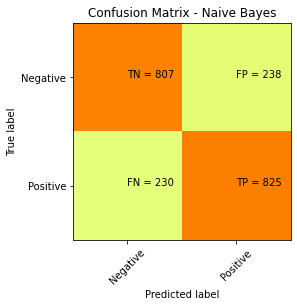

In [35]:
# Display confusion matrix for hypertuned Logistic Regression
cm = confusion_matrix(test_sentiments,y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.783


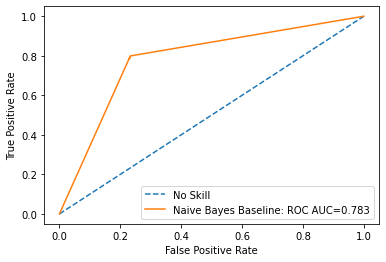

In [36]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_sentiments))]
# predict probabilities
lr_probs = gnb.predict_proba(BOW_tv_test_features.toarray())
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_sentiments, ns_probs)
lr_auc = roc_auc_score(test_sentiments, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_sentiments, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_sentiments, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, label='Naive Bayes Baseline: ROC AUC=%.3f' % (lr_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

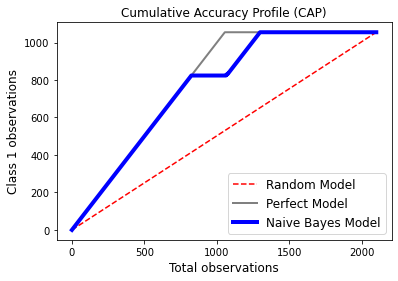

In [37]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
#plt.figure(figsize = (20, 12))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = gnb.predict_proba(BOW_tv_test_features.toarray())
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Naive Bayes Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [38]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for the Naive Bayes model: {}".format(aR / aP))

Accuracy Rate for the Naive Bayes model: 0.8982326129844214


Percentage: 78.104%


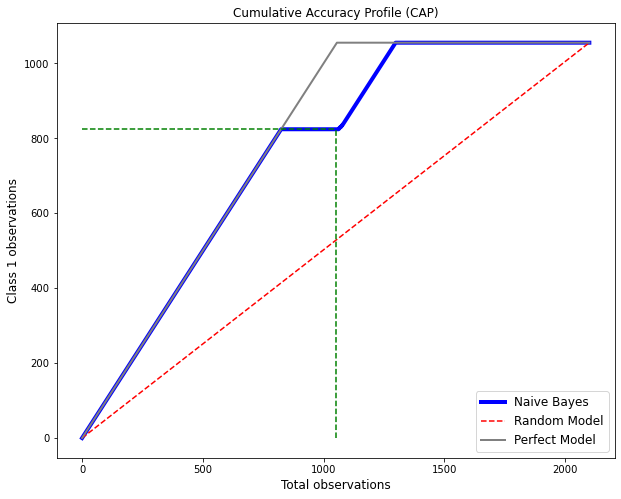

In [39]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Naive Bayes', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

### 4.2.2) Hyperparameter Tuning Naive Bayes Model<a class="anchor" id="4.2.2"></a>

* The Naive bayes model has no parameters for tuning


## 4.3) Random Forest<a class="anchor" id="5.1"></a>

### 4.3.1) Baseline Random Forest<a class="anchor" id="5.1.1"></a>

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
%%time
rf_bow_tfidf = RandomForestClassifier()

# Random Forest model on BOW-TF-IDF features
rf_bow_tfidf_predictions = meu.train_predict_model(classifier=rf_bow_tfidf, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)

Wall time: 3.62 s


In [65]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=rf_bow_tfidf_predictions,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8324
Precision: 0.8325
Recall: 0.8324
F1 Score: 0.8324

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.84      0.82      0.83      1053
           0       0.83      0.84      0.83      1047

    accuracy                           0.83      2100
   macro avg       0.83      0.83      0.83      2100
weighted avg       0.83      0.83      0.83      2100


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        868  185
        0        167  880


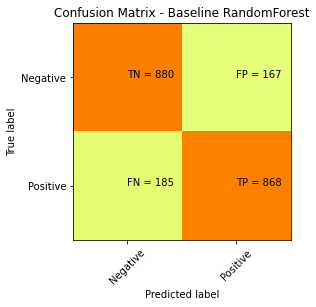

In [67]:
# Display confusion matrix for hypertuned Logistic Regression
cm = confusion_matrix(test_sentiments,rf_bow_tfidf_predictions)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Baseline RandomForest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()


No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.917


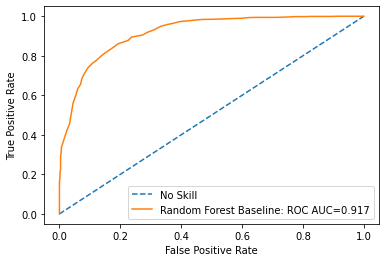

In [69]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(test_sentiments))]
# predict probabilities
rf_probs = rf_bow_tfidf.predict_proba(BOW_tv_test_features.toarray())
# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(test_sentiments, ns_probs)
rf_auc = roc_auc_score(test_sentiments, rf_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_sentiments, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(test_sentiments, rf_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(rf_fpr, rf_tpr, label='Random Forest Baseline: ROC AUC=%.3f' % (rf_auc))
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

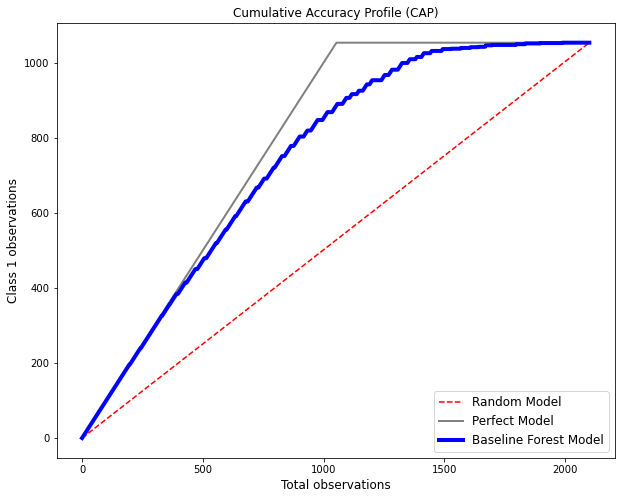

In [71]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = rf_bow_tfidf.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Baseline Forest Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

In [72]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Baseline Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Untuned Random Forest Model: 0.8413320380846646


Percentage: 83.856%


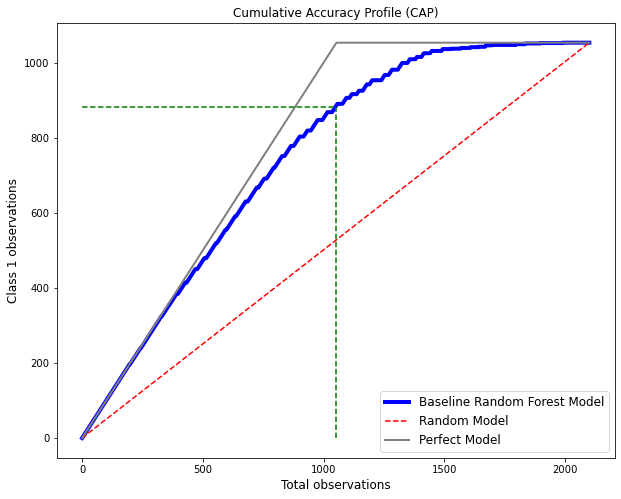

In [73]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'b', 
         label = 'Baseline Random Forest Model', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

83.00% which means we have a very good model. No signs of overfitting. 

### 4.3.2) Hyperparameter Tuning Random Forest<a class="anchor" id="5.1.2"></a>

In [74]:
%%time
rf = RandomForestClassifier()

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available values
rf_tuned_model = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_tuned_model.fit(BOW_tv_train_features, train_sentiments)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished


Wall time: 38min 6s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [75]:
print('Best Score: ', rf_tuned_model.best_score_)
print('Best Params: ', rf_tuned_model.best_params_)

Best Score:  0.8510228525642707
Best Params:  {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}


In [54]:
from sklearn.ensemble import RandomForestClassifier
# Create the tuned model
rf_tuned_tfidf = RandomForestClassifier(n_estimators= 600, min_samples_split =10, min_samples_leaf = 1, max_features= 'sqrt', max_depth = 40, bootstrap = False)

# Logistic Regression model on BOW-TF-IDF features
rf_tfidf_predictions_tuned = meu.train_predict_model(classifier=rf_tuned_tfidf, 
                                             train_features=BOW_tv_train_features, train_labels=train_sentiments,
                                             test_features=BOW_tv_test_features, test_labels=test_sentiments)


In [59]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=rf_tfidf_predictions_tuned,
                                      classes=[1,0])

Model Performance metrics:
------------------------------
Accuracy: 0.8557
Precision: 0.8557
Recall: 0.8557
F1 Score: 0.8557

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.85      0.86      0.86      1055
           0       0.86      0.85      0.85      1045

    accuracy                           0.86      2100
   macro avg       0.86      0.86      0.86      2100
weighted avg       0.86      0.86      0.86      2100


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   1    0
Actual: 1        909  146
        0        157  888


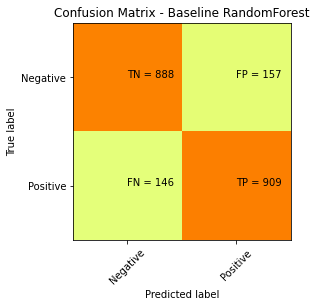

In [58]:
# Display confusion matrix for hypertuned Logistic Regression
cm = confusion_matrix(test_sentiments,rf_tfidf_predictions_tuned)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Tune RandomForest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

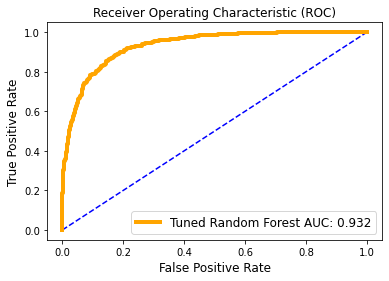

In [60]:
#ROC Curve for Tuned Random Forest
from sklearn.metrics import roc_curve, auc

#plt.figure(figsize = (20, 12))
plt.plot([0,1], [0,1], 'b--')
probs = rf_tuned_tfidf.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(test_sentiments, probs)
roc_auc = auc(fpr, tpr)
label = 'Tuned Random Forest AUC:' + ' {0:.3f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'orange', label = label, linewidth = 4)
plt.xlabel('False Positive Rate', fontsize = 12)
plt.ylabel('True Positive Rate', fontsize = 12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)

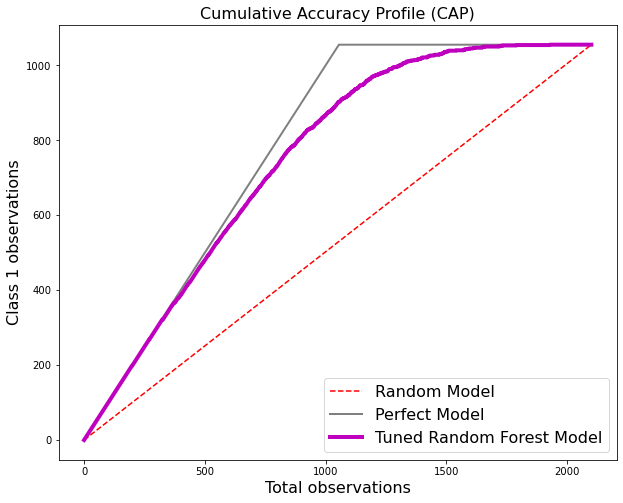

In [61]:
#CAP curve
total = len(test_sentiments)
class_1_count = np.sum(test_sentiments)
class_0_count = total - class_1_count
plt.figure(figsize = (10, 8))

# Random Model
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')

# Perfect Model
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth = 2, 
         label = 'Perfect Model')

# Trained Model
probs = rf_tuned_tfidf.predict_proba(BOW_tv_test_features)
probs = probs[:, 1]
model_y = [y for _, y in sorted(zip(probs, test_sentiments), reverse = True)]
y_values = np.append([0], np.cumsum(model_y))
x_values = np.arange(0, total + 1)
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Random Forest Model', 
         linewidth = 4)

# Plot information
plt.xlabel('Total observations', fontsize = 16)
plt.ylabel('Class 1 observations', fontsize = 16)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 16)
plt.legend(loc = 'lower right', fontsize = 16)

In [62]:
# Area under Random Model
a = auc([0, total], [0, class_1_count])

# Area between Perfect and Random Model
aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a

# Area between Trained and Random Model
aR = auc(x_values, y_values) - a

print("Accuracy Rate for Tuned Random Forest Model: {}".format(aR / aP))

Accuracy Rate for Tuned Random Forest Model: 0.8641039479353273


Percentage: 85.308%


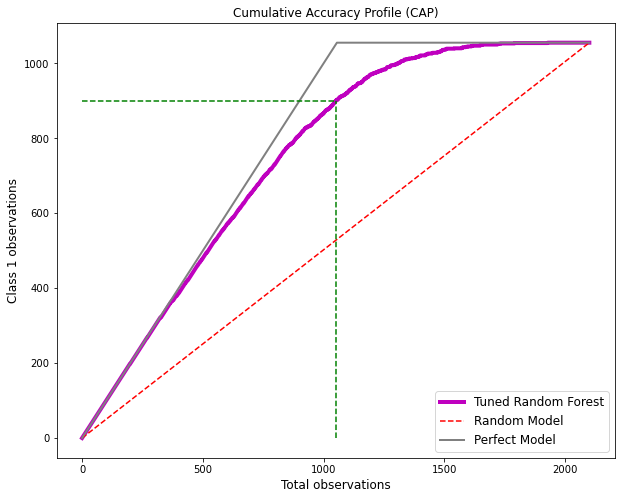

In [63]:
#Checking for overfitting

plt.figure(figsize = (10, 8))
plt.plot(x_values, 
         y_values, 
         c = 'm', 
         label = 'Tuned Random Forest', 
         linewidth = 4)
plt.plot([0, total], [0, class_1_count], c = 'r', linestyle = '--', label = 'Random Model')
plt.plot([0, class_1_count, total], 
         [0, class_1_count, class_1_count], 
         c = 'grey', 
         linewidth=2, 
         label = 'Perfect Model')

# Point where vertical line will cut trained model
index = int((50*total / 100))

## 50% Verticcal line from x-axis
plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')

## Horizontal line to y-axis from prediction model
plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')

class_1_observed = y_values[index] * 100 / max(y_values)

plt.xlabel('Total observations', fontsize = 12)
plt.ylabel('Class 1 observations', fontsize = 12)
plt.title('Cumulative Accuracy Profile (CAP)', fontsize = 12)
plt.legend(loc = 'lower right', fontsize = 12)
print("Percentage: {0:.3f}%".format(class_1_observed))

# 5. Ensemble Learning<a class="anchor" id="5"></a>

## 5.1) Bagging<a class="anchor" id="5.2"></a>

Accuracy: 0.89 (+/- 0.01) [Logistic Regression]
Accuracy: 0.76 (+/- 0.01) [Naive Bayes]
Accuracy: 0.88 (+/- 0.00) [Bagging Logistic Regression]
Accuracy: 0.78 (+/- 0.01) [Bagging Naive Bayes]


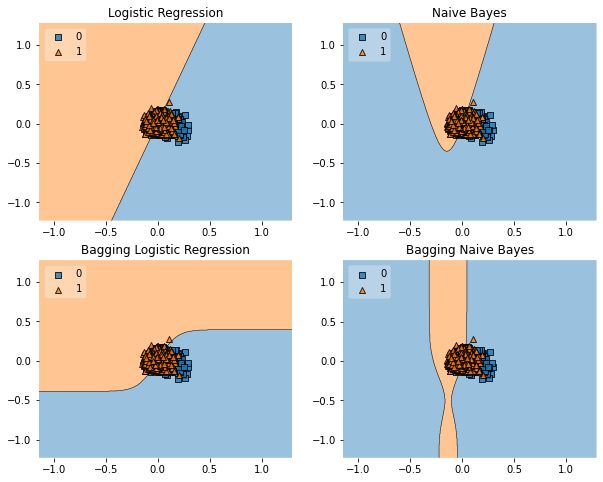

In [36]:
import itertools
import matplotlib.gridspec as gridspec
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Bagging
bagging1 = BaggingClassifier(base_estimator=lr_bow_tfidf_tuned, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=gnb, n_estimators=10, max_samples=0.8, max_features=0.8)

# Ensemble Learning
label = ['Logistic Regression', 'Naive Bayes', 'Bagging Logistic Regression', 'Bagging Naive Bayes']
clf_list = [lr_bow_tfidf_tuned, gnb, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf,BOW_tv_train_features.toarray(), train_sentiments, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(BOW_tv_train_features.toarray(), train_sentiments)
    ax = plt.subplot(gs[grd[0], grd[1]])
    # Due to the number of feature use PCA for dimension reduction
    pca = PCA(n_components = 2)
    X_train2 = pca.fit_transform(BOW_tv_train_features.toarray())
    clf.fit(X_train2,train_sentiments)
    
    fig = plot_decision_regions(X_train2,train_sentiments, clf=clf, legend=2)
    plt.title(label)

plt.show()

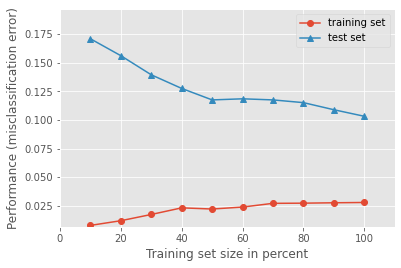

In [37]:
plt.figure()
plot_learning_curves(BOW_tv_train_features, train_sentiments,BOW_tv_test_features,test_sentiments, bagging1, print_model=False, style='ggplot')
plt.show()

In [43]:
#Ensemble Size
num_est = map(int, np.linspace(1,10,10))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=lr_bow_tfidf_tuned, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf,BOW_tv_train_features.toarray(),train_sentiments, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

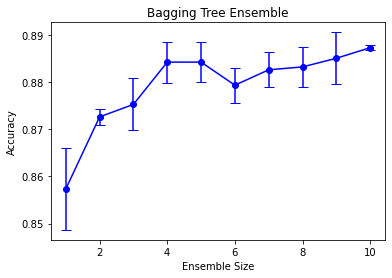

In [44]:
num_est = np.linspace(1,10,10)
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

## 5.2) Stacking<a class="anchor" id="5.2"></a>

Accuracy: 0.77 (+/- 0.01) [Naive Bayes]
Accuracy: 0.88 (+/- 0.00) [Logistic Regression]
Accuracy: 0.88 (+/- 0.00) [StackingClassifier]


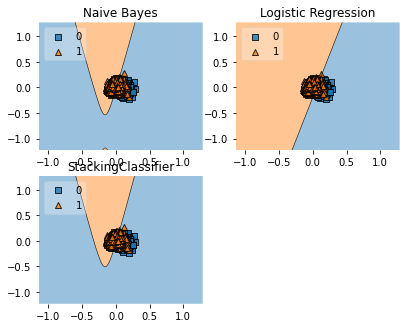

In [80]:
from mlxtend.classifier import StackingClassifier
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.gridspec as gridspec
import itertools
from sklearn.decomposition import PCA

sclf = StackingClassifier(classifiers=[gnb,lr_bow_tfidf_tuned],meta_classifier = DecisionTreeClassifier())
label = ['Naive Bayes', 'Logistic Regression','StackingClassifier']
clf_list = [ gnb,lr_bow_tfidf_tuned,sclf]

clf_cv_mean = []
clf_cv_std = []

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 3)
grid = itertools.product([0,1],repeat=2)

for clf, label,grd in zip(clf_list, label,grid):
        
    scores = cross_val_score(clf,BOW_tv_train_features.toarray(), train_sentiments, cv=3, scoring='accuracy')
    print ("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(BOW_tv_train_features.toarray(), train_sentiments)
    ax = plt.subplot(gs[grd[0], grd[1]])
    # Due to the number of feature use PCA for dimension reduction
    pca = PCA(n_components = 2)
    X_train2 = pca.fit_transform(BOW_tv_train_features.toarray())
    clf.fit(X_train2,train_sentiments)
    
    fig = plot_decision_regions(X_train2,train_sentiments, clf=clf, legend=2)
    plt.title(label)

plt.show()


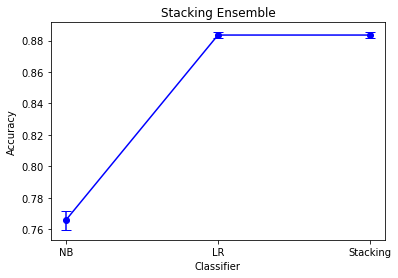

In [43]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(3), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(3), ['NB', 'LR', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

## 5.3) Boosting<a class="anchor" id="5.2"></a>

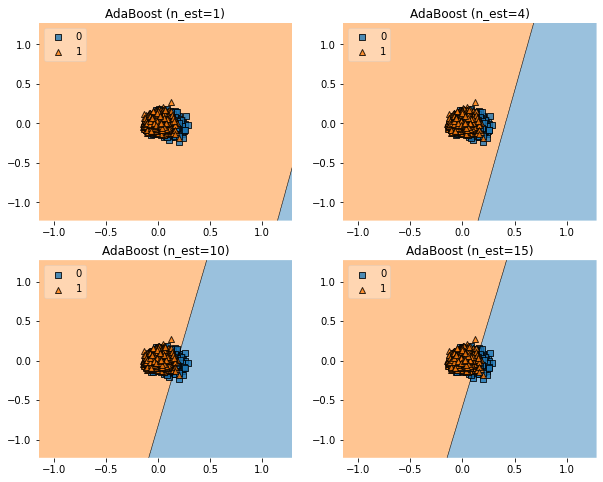

In [82]:
from sklearn.ensemble import AdaBoostClassifier
clf = lr_bow_tfidf_tuned
num_est = [1, 4, 10, 15]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=4)', 'AdaBoost (n_est=10)', 'AdaBoost (n_est=15)']

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(BOW_tv_train_features.toarray(), train_sentiments)
    ax = plt.subplot(gs[grd[0], grd[1]])
     # Due to the number of feature use PCA for dimension reduction
    pca = PCA(n_components = 2)
    X_train2 = pca.fit_transform(BOW_tv_train_features.toarray())
    boosting.fit(X_train2,train_sentiments)
    fig = plot_decision_regions(X_train2,train_sentiments, clf=boosting, legend=2)
    plt.title(label)

plt.show()

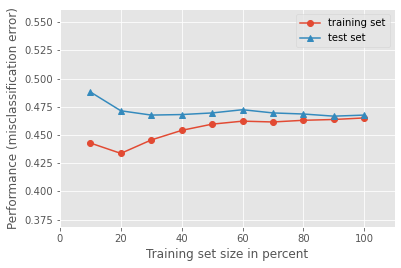

In [83]:
#learnig curve for n_est = 10
boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(BOW_tv_train_features, train_sentiments,BOW_tv_test_features,test_sentiments, boosting, print_model=False, style='ggplot')
plt.show()

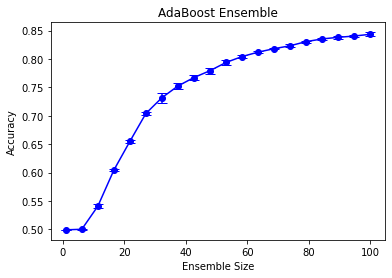

In [84]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, BOW_tv_train_features.toarray(),train_sentiments, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())
    
num_est = np.linspace(1, 100, 20)
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()